<a href="https://colab.research.google.com/github/HikariJadeEmpire/Image_classification_DeepLearning/blob/main/MobileNet_with_GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to Google drive
- List GPU
- Check libraries version

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# List all NVIDIA GPUs as avaialble in this computer (or Colab's session)
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
print( f"Matplotlib {matplotlib.__version__}\n" )

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]

NumPy 1.23.5

Matplotlib 3.7.1

TensorFlow 2.14.0
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 0 GPU(s):


# Import images
- Split Train & Test data

In [ ]:
import os
import cv2
import random

def train_test_split(main_dir,categories,n_train=70) :

  IMG_SIZE = 224
  train_data =[]
  test_data =[]

  for category in categories:
    path = os.path.join(main_dir, category)
    cat = categories.index(category)

    for i,img in enumerate(os.listdir(path)):
      try:
        img_array = cv2.imread(os.path.join(path,img))
        img_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
      except Exception as e :
        print("Something went wrong : {e}".format(e=e))

      if i <= n_train :
        train_data.append([img_array,cat])
      else :
        test_data.append([img_array,cat])

  random.seed(112) # Set seed to fix random output
  random.shuffle(train_data)
  random.shuffle(test_data)

  x_train=[]; y_train=[]
  x_test=[]; y_test=[]

  for features in train_data:
    x_train.append(features[0])
    y_train.append(features[1])

  for features in test_data:
    x_test.append(features[0])
    y_test.append(features[1])

  try:
    x_train = np.array(x_train, dtype='uint8').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    x_test = np.array(x_test, dtype='uint8').reshape(-1, IMG_SIZE, IMG_SIZE, 3)

    y_train = np.array(y_train, dtype='uint8').reshape(-1, 1)
    y_test = np.array(y_test, dtype='uint8').reshape(-1, 1)

  except Exception as e :
        print("Something went wrong : {e}".format(e=e))

  return [x_train, y_train , x_test, y_test]

In [ ]:
main_dir = "drive/MyDrive/myColab_Notebooks/DeepLearning/Banknote_img_data" # Your Google drive's images directory
categories = ["twenty","fifty","hundred","fivehundred","thousand"] # categories will become classes of 0,1,2,...

x_train, y_train , x_test, y_test = train_test_split(main_dir,categories)

# example result
print(x_train[0].shape)
print(x_train.shape)
print(y_train.shape)

(224, 224, 3)
(355, 224, 224, 3)
(355, 1)


In [ ]:
print("Train = {a} , Test = {b}".format(a=len(x_train), b=len(x_test)) )

Train = 355 , Test = 188


## _EDA

In [ ]:
print(type(x_train), type(x_train[0]), x_train[0].dtype, x_train.shape)
print(type(x_test), type(x_test[0]), x_test[0].dtype, x_test.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> uint8 (355, 224, 224, 3)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> uint8 (188, 224, 224, 3)


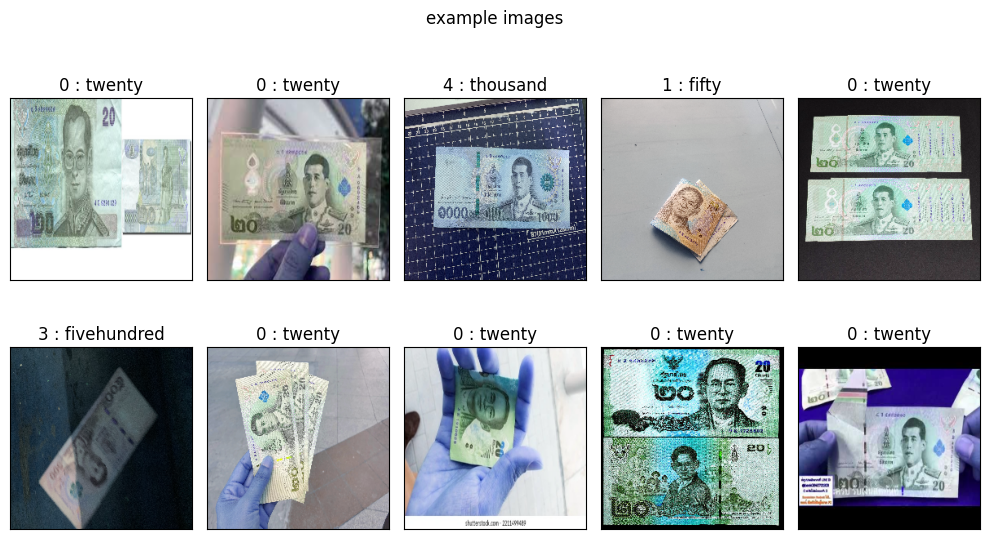

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,6), subplot_kw = {'xticks':[],'yticks':[]} )

n = 0
for i,img in zip(y_train,x_train) :
  if n < 10 :
    axes.flat[n].imshow(img)
    axes.flat[n].set_title(f"{i[0]} : {categories[i[0]]}")
    n+=1
  else: break

fig.suptitle("example images")
fig.tight_layout()
fig.show()

## _Change data type

In [ ]:
x_train = tf.keras.applications.mobilenet.preprocess_input(x_train)
x_test = tf.keras.applications.mobilenet.preprocess_input(x_test)

# check
print(type(x_train), type(x_train[0]), x_train[0].dtype, x_train.shape)
print(type(x_test), type(x_test[0]), x_test[0].dtype, x_test.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> float32 (355, 224, 224, 3)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> float32 (188, 224, 224, 3)


# CNN Model import
- Non-adjust selected model
- Adjust selected model

In [ ]:
# Set fixed seeding values for reproducability during experiments
np.random.seed(23)
tf.random.set_seed(56)

## _Non-adjust MobileNet
 - but dropping the classifier and

In [ ]:
mobile = tf.keras.applications.MobileNet(
    include_top=True,
    weights="imagenet",
    classifier_activation="softmax"
)

mobile.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                 

### __Prediction

In [ ]:
pred = mobile.predict( x_train[0:2] )

# Decode the top 10 classes
pred = tf.keras.applications.mobilenet.decode_predictions(pred, top=5)

35363/35363 [==============================] - 0s 0us/step


In [ ]:
for i, prediction in enumerate(pred):
  print(f"\nImage No.{i+1}\n")
  for pp in prediction:
    print( f"Rank {i+1}: {pp}" )


Image No.1

Rank 1: ('n07248320', 'book_jacket', 0.4341027)
Rank 1: ('n03291819', 'envelope', 0.19808613)
Rank 1: ('n06596364', 'comic_book', 0.106006324)
Rank 1: ('n04317175', 'stethoscope', 0.024716387)
Rank 1: ('n03223299', 'doormat', 0.021698512)

Image No.2

Rank 2: ('n03666591', 'lighter', 0.2028417)
Rank 2: ('n02786058', 'Band_Aid', 0.14238648)
Rank 2: ('n03314780', 'face_powder', 0.05178497)
Rank 2: ('n03825788', 'nipple', 0.04768581)
Rank 2: ('n03908618', 'pencil_box', 0.041380037)


## _Adjust MobileNet

In [ ]:
inp_shape = ( 224,224,3 )

mobile = tf.keras.applications.MobileNet(
    input_shape=inp_shape,
    include_top=False,
    weights="imagenet",
)

mobile.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                 

### __Access and unfreeze layer(s) in Keras's model

In [ ]:
# Recursively freeze all layers in the model

mobile.trainable = False

ly = 80

for i,layer in enumerate(mobile.layers):
  if (ly-3) < i < ly :
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )
  elif i == ly :
    layer.trainable = True
    print( f"\nLayer {i}: name = {layer.name} , trainable = {layer.trainable}" )
  elif ly < i < (ly+4) :
    layer.trainable = True
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 78: name = conv_pw_12_bn , trainable = False
Layer 79: name = conv_pw_12_relu , trainable = False

Layer 80: name = conv_dw_13 , trainable = True
Layer 81: name = conv_dw_13_bn , trainable = True
Layer 82: name = conv_dw_13_relu , trainable = True
Layer 83: name = conv_pw_13 , trainable = True


### __Combine new classification layers

In [ ]:
# MobileNet

x = mobile.output

# Classifier

x = tf.keras.layers.GlobalAveragePooling2D( keepdims=True, name='Glob_AvPooling' )(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Conv2D( filters=5, kernel_size=1, strides=(1, 1), activation=None, padding="valid", name='conv_preds' )(x)
x = tf.keras.layers.Reshape((-1,))(x)
out = tf.keras.layers.Activation('softmax')(x)

# Construct the main model

model = tf.keras.Model(mobile.inputs, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

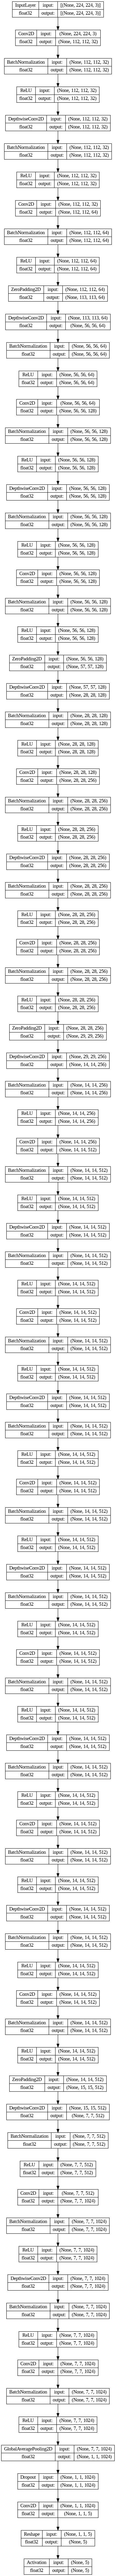

In [ ]:
tf.keras.utils.plot_model(model, to_file='cnn1_sequential.png', show_shapes=True, show_dtype=True, show_layer_names=False, dpi=96)

# Compile and train the model

In [ ]:
model.compile( loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"] )

In [ ]:
# save model & weights every epoch

checkpoint_path = "drive/MyDrive/myColab_Notebooks/DeepLearning/weight_n_bias/MobileNet_bestmodel_round00.h5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                                save_weights_only=True,
                                                                monitor='val_loss',
                                                                mode='min',
                                                                verbose=0,
                                                                save_best_only=True
                                                               )

## _Load weights & model

In [ ]:
# model.load_weights(checkpoint_path)

## _Train

In [ ]:
# Train the model
his = model.fit( x_train, y_train, batch_size=120,
                            epochs=20,
                            verbose=1,
                            validation_split=0.2,
                            callbacks=[model_checkpoint_callback]
                      )

Epoch 1/15
3/3 [==============================] - 34s 10s/step - loss: 1.4219 - acc: 0.5951 - val_loss: 1.4114 - val_acc: 0.4789
Epoch 2/15
3/3 [==============================] - 33s 11s/step - loss: 1.0050 - acc: 0.6162 - val_loss: 1.0109 - val_acc: 0.5775
Epoch 3/15
3/3 [==============================] - 35s 12s/step - loss: 0.8141 - acc: 0.6761 - val_loss: 0.9634 - val_acc: 0.5493
Epoch 4/15
3/3 [==============================] - 28s 10s/step - loss: 0.7862 - acc: 0.7324 - val_loss: 1.0192 - val_acc: 0.6620
Epoch 5/15
3/3 [==============================] - 26s 9s/step - loss: 0.6518 - acc: 0.7782 - val_loss: 1.0587 - val_acc: 0.5775
Epoch 6/15
3/3 [==============================] - 33s 11s/step - loss: 0.6791 - acc: 0.7676 - val_loss: 0.8407 - val_acc: 0.6761
Epoch 7/15
3/3 [==============================] - 23s 8s/step - loss: 0.4803 - acc: 0.8521 - val_loss: 0.8216 - val_acc: 0.6620
Epoch 8/15
3/3 [==============================] - 28s 8s/step - loss: 0.4147 - acc: 0.8944 - val_lo

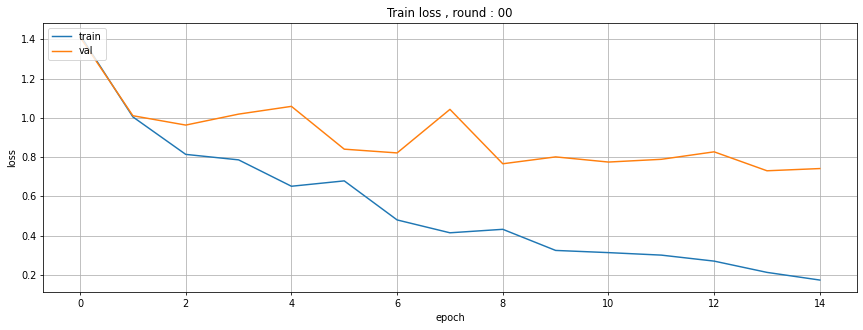

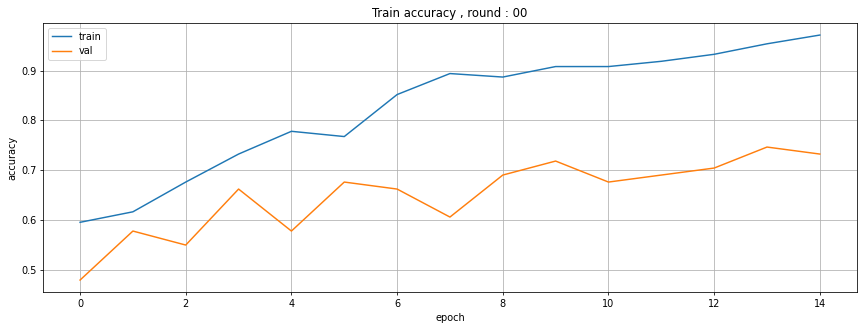

In [ ]:
round = '00'

# Summarize history for loss
plt.figure(figsize=(15,5), dpi = 70)
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('Train loss , round : '+round)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

# Summarize history for accuracy
plt.figure(figsize=(15,5), dpi = 70)
plt.plot(his.history['acc'])
plt.plot(his.history['val_acc'])
plt.title('Train accuracy , round : '+round)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

# Evaluate the model on test set

In [ ]:
results = model.evaluate(x_test, y_test, batch_size=30)
print( f"{model.metrics_names} = {results}" )

7/7 [==============================] - 12s 2s/step - loss: 1.4633 - acc: 0.5213
['loss', 'acc'] = [1.4633208513259888, 0.521276593208313]


## _Inspect Results

In [ ]:
plt.rcParams["axes.linewidth"] = 5

def color_frame( ax, y_true, y_pred ):
  color = 'green' if (y_true == y_pred) else 'red'
  ax.spines['bottom'].set_color(color)
  ax.spines['top'].set_color(color)
  ax.spines['right'].set_color(color)
  ax.spines['left'].set_color(color)

samples.shape=(10, 224, 224, 3)


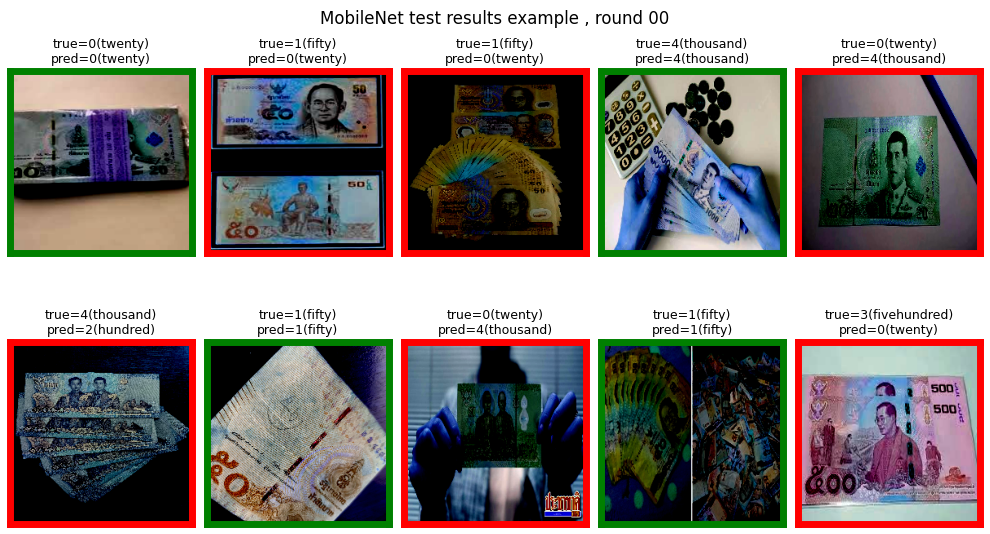

In [ ]:
# Get a batch of samples
n = 10
samples = x_test[:n]
print(f'{samples.shape=}')

# Predict a batch of samples
y_pred = model.predict(samples, verbose = False)

import warnings
warnings.filterwarnings("ignore")

# Plot

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,6), subplot_kw = {'xticks':[],'yticks':[]} )

# Interpret the results
for i in range(n):
  axes.flat[i].imshow( x_test[i] )
  axes.flat[i].set_title( f"true={y_test[i][0]}({categories[int(y_test[i])]})\npred={np.argmax(y_pred[i])}({categories[np.argmax(y_pred[i])]})"
                         , fontsize=9 )
  color_frame(axes.flat[i], y_test[i], np.argmax(y_pred[i]))

fig.tight_layout()
fig.suptitle("MobileNet test results example , round "+round)
fig.show()

## _get scores

In [ ]:
his.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [ ]:
mymin = np.min(his.history['val_loss'])

lc = his.history['val_loss'].index(mymin)

print(f"Minimum validation loss scores :\n\n acc : {his.history['acc'][lc]}\n val_acc : {his.history['val_acc'][lc]}\n loss : {his.history['loss'][lc]}\n val_loss : {mymin}")

Minimum validation loss scores :

 acc : 0.9542253613471985
 val_acc : 0.7464788556098938
 loss : 0.21306352317333221
 val_loss : 0.7306254506111145


# Grad-CAM

In [ ]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = tf.keras.models.Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)

            loss = predictions[:, tf.argmax(predictions[0])]

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.4,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [ ]:
def before_gradCam_plot( layer_name, model, images_dir ) :

  grad = []

  for im in images_dir :

    im = cv2.imread(im)
    image = cv2.resize(im, (224, 224))
    image = image.astype('float32') / 255
    image = np.expand_dims(image, axis=0)

    preds = model.predict(image ,verbose=0)
    i = np.argmax(preds[0])

    icam = GradCAM(model, i, layer_name)
    heatmap = icam.compute_heatmap(image)
    heatmap = cv2.resize(heatmap, (224, 224))

    image = cv2.resize(im, (224, 224))
    (heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.3)

    grad.append(output)

  return grad

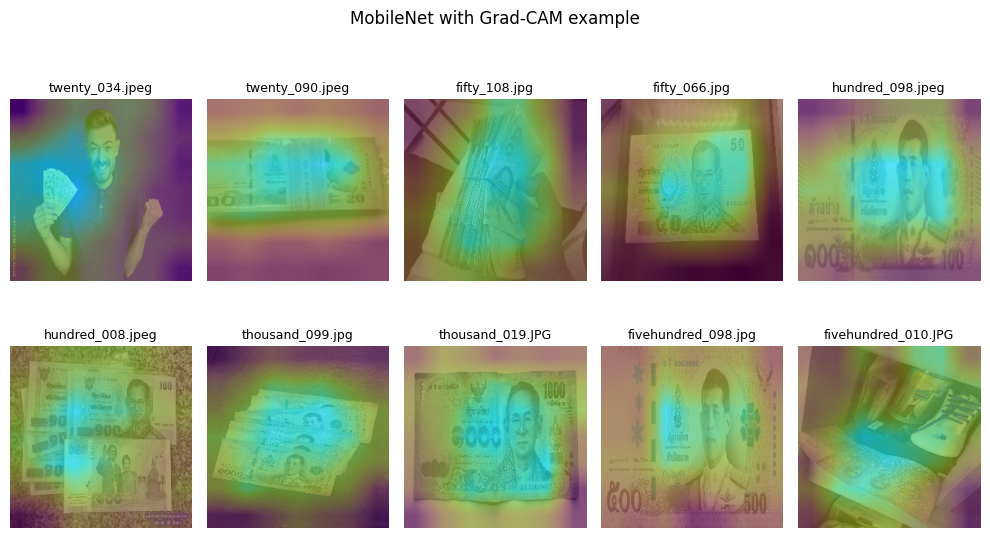

In [ ]:
layer_name = 'conv_pw_13_relu'
images = [main_dir+'/twenty/twenty_034.jpeg',main_dir+'/twenty/twenty_090.jpeg',main_dir+'/fifty/fifty_108.jpg',main_dir+'/fifty/fifty_066.jpg',
          main_dir+'/hundred/hundred_098.jpeg',main_dir+'/hundred/hundred_008.jpeg',main_dir+'/thousand/thousand_099.jpg',main_dir+'/thousand/thousand_019.JPG',
          main_dir+'/fivehundred/fivehundred_098.jpg',main_dir+'/fivehundred/fivehundred_010.JPG'
          ]

grad = before_gradCam_plot( layer_name, model, images_dir = images )

# Plot

plt.rcParams["axes.linewidth"] = 0
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,6), subplot_kw = {'xticks':[],'yticks':[]} )

for i in range(10):
  im = images[i].split('/')[-1]
  axes.flat[i].set_title( im, fontsize=9 )
  axes.flat[i].imshow(grad[i])

fig.suptitle("MobileNet with Grad-CAM example")
fig.tight_layout()